<a href="https://colab.research.google.com/github/ChihyunAhn0309/Reinforcement_Learning/blob/main/25s_cs377_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS377 Reinforcement Learning - Programming Assignment 1

---






## Submission Guideline

**How to submit**
*   Fill out <mark> TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
*   Submit one file: {student_ID}.ipynb to KLMS

    e.g. 20251234.ipynb
* **Late submission policy**: After the submission deadline, you will immediately lose 10% of the score, another 10% after 24 hours later, and so on. Submissions after 72 hours (3 days) will not be counted.

**Note**
*   Make a copy of this .ipynb file. Do not directly edit this file.
*   You are required to use numpy, do not use neither pytorch nor tensorflow.
*   Check whether your whole cells work well by restarting runtime code and running all before the submission.
*   TA will look into the implemented functions, their validity and give corresponding score to each <mark> TODO</mark> problem.
*   Ask questions through KLMS so that you can share information with other students.
*   TA in charge: Doojin Baek (doojin.a.baek@kaist.ac.kr)

**In this programming assignment, you will**
* Learn how to use `gym` environment for reinforcement learning framework
* Implement basic dynamic programming algorithms

## 1. Gym Tutorial

### 1.1. What is Gym?
Gym is a project that provides an API for reinforcement learning environments that include implementations of common environments: cartpole, pendulum, mountain-car, mujoco, atari, and more. The details of gym package can be checked [here](https://www.gymlibrary.dev/content/basic_usage/).

The API contains four key functions: `make`, `reset`, `step` and `render` that this basic usage will introduce you to. At the core of Gym is `Env` which is a high level python class representing a markov decision process from reinforcement learning theory.

### 1.2. Initializing and Interacting with Environments
The following is the basic preparation for installing gym and importing required packages.

In [693]:
!pip install gymnasium

import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time

Initializing environments is very easy in Gym and can be done via the `make` function. Throughout this homework, we will use `FrozenLake` environment.

In [694]:
map_size = 4
is_slippery = False
env = gym.make("FrozenLake-v1", desc=None, map_name=f"{map_size}x{map_size}", is_slippery=is_slippery).unwrapped

The classic **agent-environment loop** pictured below is simplified representation of reinforcement learning that Gym implements.

<img src="https://gymnasium.farama.org/_images/AE_loop_dark.png" width="340" height="260">

This loop is implemented using the following gym code.

In [695]:
observation = env.reset()  # start new episode
for _ in range(10):

  action = env.action_space.sample()  # sample random action from env
  print(action)
  observation, reward, terminated, truncated, info = env.step(action)  # next state
  print(observation, reward, terminated, info)

  if terminated:  # if the episode is over
    observation = env.reset()

env.close()

3
0 0.0 False {'prob': 1.0}
0
0 0.0 False {'prob': 1.0}
3
0 0.0 False {'prob': 1.0}
2
1 0.0 False {'prob': 1.0}
1
5 0.0 True {'prob': 1.0}
2
1 0.0 False {'prob': 1.0}
3
1 0.0 False {'prob': 1.0}
3
1 0.0 False {'prob': 1.0}
0
0 0.0 False {'prob': 1.0}
3
0 0.0 False {'prob': 1.0}


After initializing the environment, we `reset` the environment to get the first observation of the environment.

Next, the agent performs an action in the environment, `step`, this can be imagined as moving a agent or pressing a button on a games’ controller that causes a change within the environment. As a result, the agent receives a new observation from the updated environment along with a reward for taking the action. This reward could be for instance positive for reaching to goal or a negative reward for moving into lava. One such action-observation exchange is referred to as a timestep.

However, after some timesteps, the environment may end, this is called the terminal state. For instance, the robot may have crashed, or the agent have succeeded in completing a task, the environment will need to stop as the agent cannot continue. In gym, if the environment has terminated, this is returned by `step`. If terminated is true then reset should be called next to restart the environment.

### 1.3. FrozenLake Investigation

Throughout this HW, we are going to use `FronzenLake` environment. The goal of the agent in `FrozenLake` is **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:
- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:
- `is_slippery=False`: The agent always move in the intended direction due to the non-slippery nature of the frozen lake.
- `is_slippery=True`: The agent may not always move in the intended direction due to the slippery nature of the frozen lake (stochastic).

The below is the visualization of `FrozenLake` environment. You can find more details of environment [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/).

![alt text](https://gymnasium.farama.org/_images/frozen_lake.gif)

Now let's check environment variables in `FrozenLake`.

In [696]:
env.reset()  # start a new episode

obs_sample = env.observation_space.sample()
act_sample = env.action_space.sample()

print("Observation Space: ", env.observation_space)
print("Observation Sample: ", obs_sample)  # Sample a random observation
print("Action Space Dimension: ", env.action_space.n)
print("Action Sample: ", act_sample)  # Sample a random action
tr = env.P[obs_sample][act_sample]  # Transition probability
print("Transition:", tr)  # prob, next_state, reward, done

Observation Space:  Discrete(16)
Observation Sample:  9
Action Space Dimension:  4
Action Sample:  3
Transition: [(1.0, 5, 0.0, True)]


We see with `Observation Space Shape Discrete(16)` that the observation is a value representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**

The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

`env.P[o][a]` gives list of transitions that can happen when doing action `a` at state `o`. Note that next state may not be deterministic (This will be important when we deal with `slippery FronzenLake`.  

## 2. Dynamic Programming

### 2.1. Policy Evaluation

Now, let's start implementing basic algorithms in Dynamic Programming! The first algorithm is ***policy evaluation***. If the environment's dynamics is completely known, we can calculate the value function using Bellman equation. Bellman equation for policy evaluation is as follows:
$$v_{k+1}(s)=E_{\pi}[R_{t+1}+\gamma v_{k}(S_{t+1})|S_t=s] \\
=\sum_{a} \pi(a|s) \sum_{s',r} p(s',r|s,a) [r+\gamma v_{k}(s')]
$$
For more detailed algorithm, refer to figure 4.1 of textbook.

We will start from the random policy for policy evaluation and improve it later. First, let's implement policy that selects actions following uniform distribution.

<mark>TODO-1</mark> Implement the random policy (discrete uniform).

In [697]:
######## TODO ########
# (hint) policy: numpy array with size [s,a], each element represents probability of action given state
random_policy = np.array([[1/4, 1/4, 1/4, 1/4] for _ in range(map_size**2)])
######################

To monitor how each DP algorithms run for each iterations, we want to visualize the value function with heatmap so that we can easily see how value changes when the policy changes (or update is done).

<mark>TODO-2</mark> Implement the visualization of value table with heatmap.

In [698]:
def visualize_value_table(value, map_size):
    """
    Visualze value function for FrozenLake environment

    Args:
        value: numpy array with size [s,], value table
        map_size: int, FrozenLake map size
    Returns:
        None
    """
    ######## TODO ########
    # (hint) reshape value and use plt.matshow()
    mat_value = np.reshape(value, (map_size, map_size))
    plt.matshow(mat_value)
    ######################
    plt.clim(0, 1)
    plt.colorbar()
    plt.show()
    plt.close()

<mark>TODO-3</mark> Implement the policy evaluation function.

In [699]:
from collections.abc import Mapping
def policy_evaluation(policy, env, discount_factor=0.9, theta=0.00001, map_size=4):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.

    Args:
        policy: numpy array with size [s,a], each element represents probability of action given state
        env: gym environment
        discount_factor: float, gamma discount factor
        theta: float, stopping criteria
        map_size: int, FrozenLake map size
    Returns:
        V_new: numpy array with size [s,]
    """
    V_pre, V_new = None, None
    ######## TODO ########
    initial = 1
    V_pre = np.zeros(np.square(map_size))
    V_new = np.zeros(np.square(map_size))
    while(True):
      if(np.all(np.abs(V_new - V_pre) < theta) and initial == 0):
        break
      else:
        initial = 0
        V_pre = np.copy(V_new)
        for i in range(map_size**2):
          Return = 0
          for k in range(4):
            tr = env.P[i][k]
            if(is_slippery == False):
              Return = policy[i][k] * tr[0][0] * (tr[0][2] + discount_factor*V_pre[tr[0][1]]) + Return
            else:
              num_row = np.shape(tr)[0]
              expectation = 0
              for j in range(num_row):
                expectation = tr[j][0]*(tr[j][2] + discount_factor*V_pre[tr[j][1]]) + expectation
              Return = policy[i][k] * expectation + Return
          V_new[i] = Return
    ######################
    return V_new

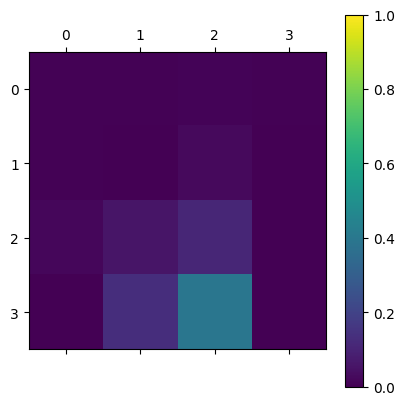

In [700]:
# Check value table
value_table = policy_evaluation(random_policy, env)
value_table_ans = np.array([0.0044593, 0.0042131, 0.01006041, 0.00411379,
                            0.0067141, 0., 0.02633197, 0.,
                            0.01867277, 0.05760567, 0.10697105, 0.,
                            0., 0.13038228, 0.39148958, 0.])
assert np.all(np.abs(value_table - value_table_ans) < 1e-3)
visualize_value_table(value_table, map_size)

### 2.2. Policy Iteration

The reason for computing the value function for a policy is to help find better
policies. Suppose we have determined the value function $v_{\pi}$ for an arbitrary deterministic policy $\pi$. Then, we can have new greedy policy $\pi'$ via policy improvement from following equation.

$$
\pi'(s)= \text{argmax}_{a} \sum_{s',r} p(s',r|s,a) [r+\gamma v_{\pi}(s')]
$$

Once a policy $\pi$ has been improved using $v_{\pi}$ to yield a better policy $\pi'$, we can then compute $v_{\pi'}$ and improve it again to yield an even better $\pi''$. We can thus obtain a sequence of monotonically improving policies and value functions:

$$
\pi_{0} ⟶^{e} v_{\pi_{0}} ⟶^{i} \pi_{1} ⟶^{e} v_{\pi_{1}} ⟶^{i} \pi_{2} … ⟶^{i} \pi_{*} ⟶^{e} v_{\pi_{*}}
$$

where $⟶^{e}$ denotes policy evaluation and $⟶^{i}$ denotes policy improvement. Each policy is guaranteed to be a strict improvement over the previous one (unless it is already optimal). Because a finite MDP has only a finite number
of policies, this process must converge to an optimal policy and optimal value
function in a finite number of iterations.

This way of finding an optimal policy is called ***policy iteration***. For more detailed algorithm, refer to figure 4.3 of textbook.

For step-by-step implementation of the algorithm, let's implement a helper function first.
One step lookahead function calculates action-value as follows.

$$q_{\pi}(s,a)= \sum_{s',r} p(s',r|s,a) [r+\gamma v_{\pi}(s')]
$$

<mark>TODO-4</mark> Implement the one step lookahead function.

In [701]:
def one_step_lookahead(state, V, env, discount_factor):
    """
    Helper function to calculate the value for every action in a given state.

    Args:
        state: integer, current state
        V: numpy array with size [s,], value table
        env: gym environment
        discount_factor: float, gamma discount factor
    Returns:
        A: numpy array with size [a,], action value table for state
    """
    A = None
    ######## TODO ########
    A = np.zeros(env.action_space.n)
    if(is_slippery == True):
      for i in range(env.action_space.n):
        tr = env.P[state][i]
        num_row = np.shape(tr)[0]
        expectation = 0
        for j in range(num_row):
          expectation = tr[j][0]*(tr[j][2] + discount_factor*V[tr[j][1]]) + expectation
        A[i] = expectation
    else:
      for i in range(env.action_space.n):
        tr = env.P[state][i]
        A[i] = tr[0][0]*(tr[0][2] + discount_factor*V[tr[0][1]])
    ######################
    return A

This time, we will start from **Going Left** policy (initial policy) for policy iteration.

<mark>TODO-5</mark> Implement the **Going Left** policy.

In [702]:
def go_left_policy(env):
    """
    Go Left Policy

    Args:
        env: gym environment
    Returns:
        policy: numpy array with size [s,a], each element represents probability of action given state
    """
    policy = None
    ######## TODO ########
    policy = np.array([[1,0,0,0] for _ in range(map_size ** 2)])
    ######################
    return policy

To monitor how policy changes for each iterations, we want to visualize the policy in `FrozenLake` so that we can easily see how policy changes based on value function.

<mark>TODO-6</mark> Implement the visualization of greedy policy.

In [703]:
def visualize_greedy_policy(policy, map_size):
    """
    Visualize greedy policy based on policy. For e.g., printed result will be

    Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
    [[0 0 0 0]
    [0 0 1 0]
    [0 1 1 0]
    [0 2 2 0]]

    Args:
        policy: numpy array with size [s,a], each element represents probability of action given state
        map_size: int, FrozenLake map size
    Returns:
        None
    """
    print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
    ######## TODO ########
    mat_greedy_policy = np.reshape(policy, (map_size, map_size))
    print(mat_greedy_policy)

    ######################
    return

<mark>TODO-7</mark> Implement the policy iteration.

In [704]:
def policy_iteration(env, init_policy, discount_factor=0.9, map_size=4):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy until an optimal policy is found.

    Args:
        env: gym environment
        init_policy: numpy array with size [s,a], each element represents probability of action given state
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table

    (IMPORTANT!): For each iteration, use visualize_value_table, and visualize_greedy_policy function for visualization!
    """

    policy, V = None, None
    ######## TODO ########
    cur_policy = np.copy(init_policy)
    greedy_policy = np.zeros(map_size ** 2)
    old_policy = np.zeros(map_size ** 2)
    count = 0
    while(True):
      if(np.all(greedy_policy == old_policy) and count >= 10):
        policy = greedy_policy
        V = state_value
        break
      elif(np.all(greedy_policy == old_policy)):
        count = count + 1
      else:
        count = 0
      old_policy = np.copy(greedy_policy)
      state_value = policy_evaluation(cur_policy, env)
      cur_policy = np.array([np.zeros(env.action_space.n) for _ in range(map_size ** 2)])
      for i in range(map_size ** 2):
        greedy_action = np.argmax(one_step_lookahead(i, state_value, env, discount_factor))
        cur_policy[i][greedy_action] = 1
        greedy_policy[i] = greedy_action
      visualize_value_table(state_value, map_size)
      visualize_greedy_policy(greedy_policy, map_size)

    ######################

    return policy, V

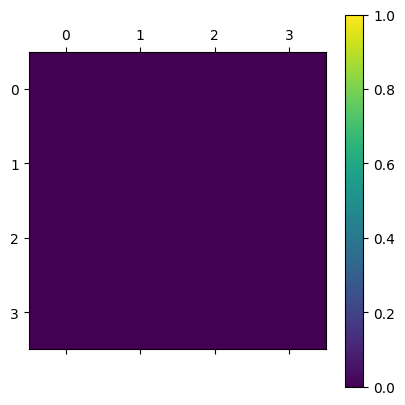

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]]


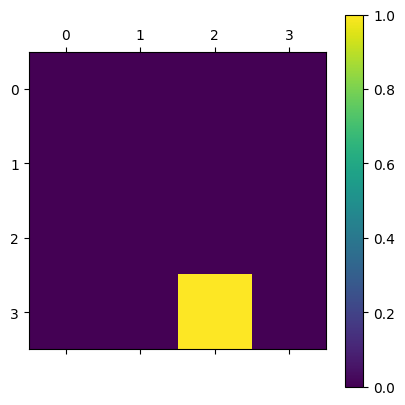

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 2. 2. 0.]]


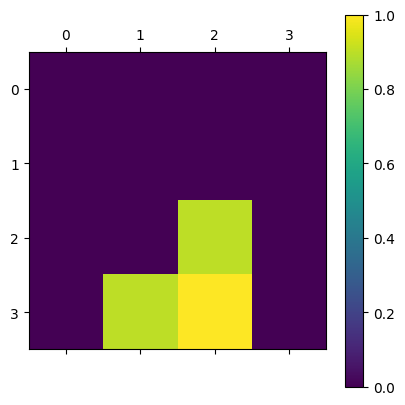

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 2. 2. 0.]]


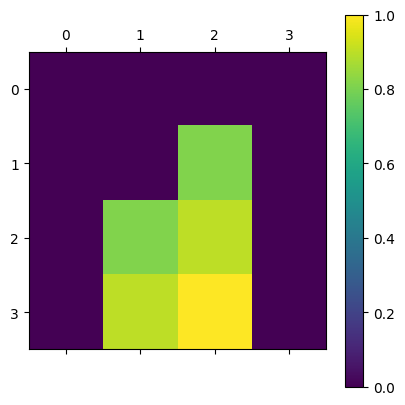

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


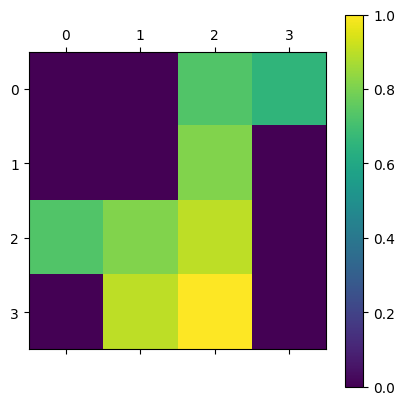

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


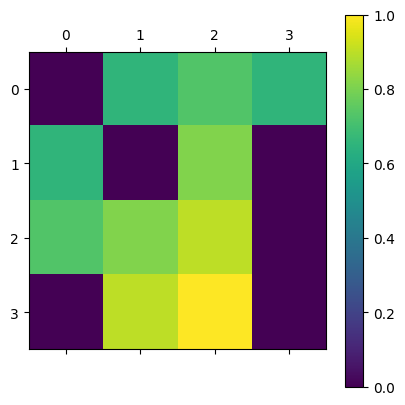

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


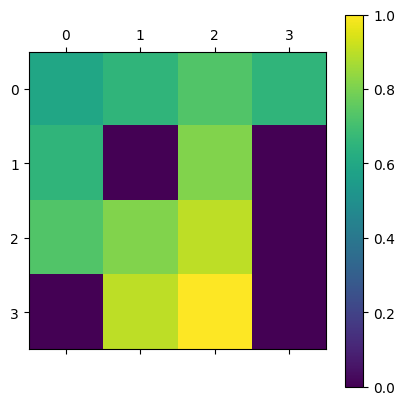

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


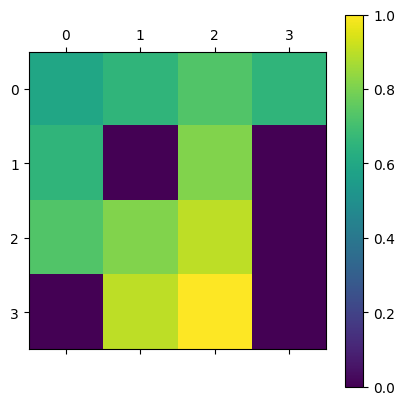

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


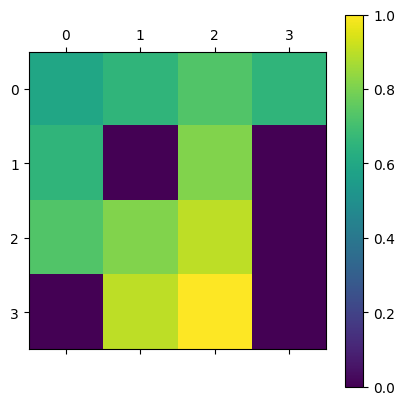

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


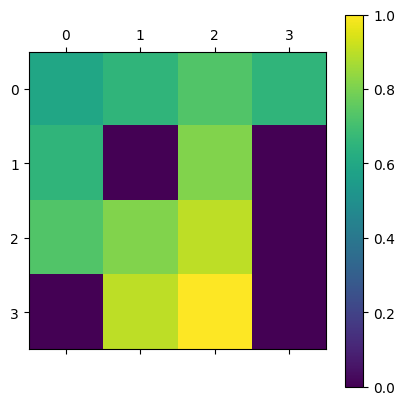

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


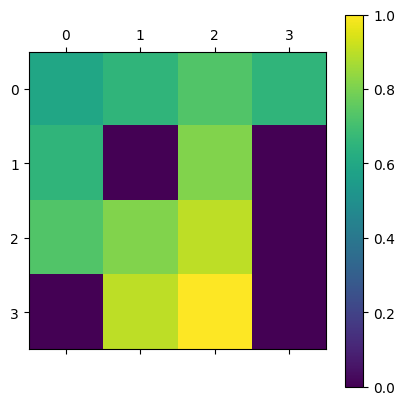

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


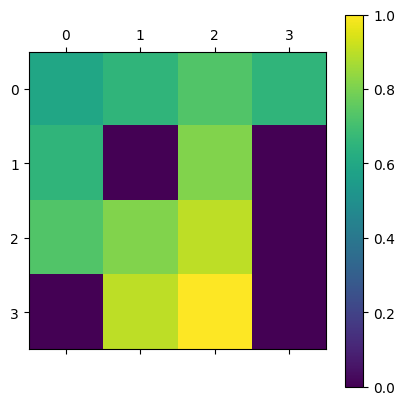

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


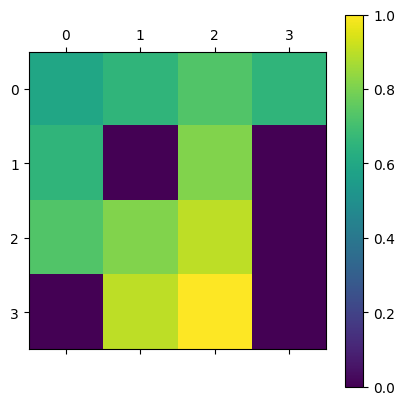

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


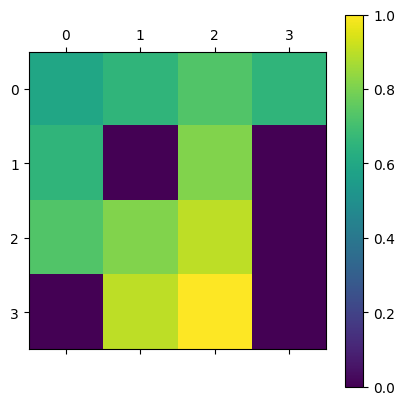

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


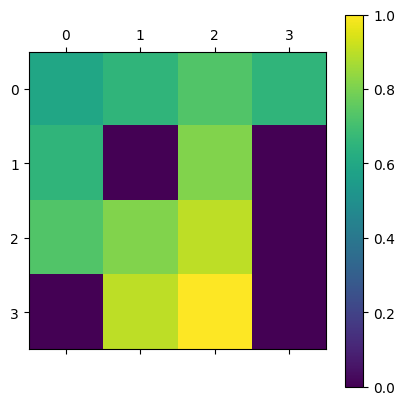

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


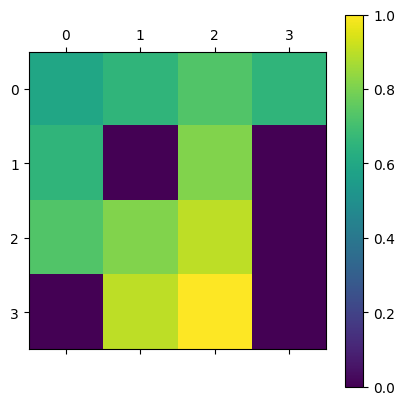

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


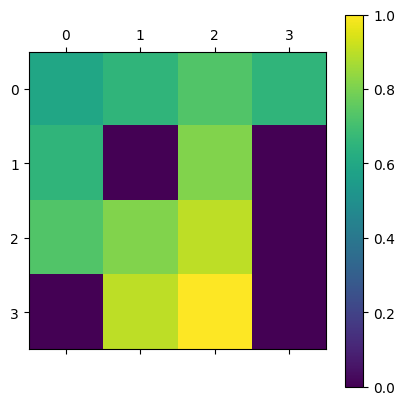

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


In [705]:
policy, v = policy_iteration(env, go_left_policy(env))

### 2.3. Value Iteration

One drawback to policy iteration is that each of its iterations involves policy
evaluation, which may itself be a protracted iterative computation requiring
multiple sweeps through the state set.
If policy evaluation is done iteratively, then convergence exactly to $v_{\pi}$ occurs only in the limit. In fact, the policy evaluation step of policy iteration can be truncated in several ways without losing the convergence guarantees of policy iteration.
One important special case is when policy evaluation is stopped after just one
sweep (one backup of each state).
This algorithm is called ***value iteration***.
It can be written as a particularly simple backup operation that combines the policy improvement and truncated policy evaluation steps:

$$
v_{k+1}(s)=\text{max}_{a} \textbf{E}[R_{t+1}+\gamma v_{k}(s_{t+1}) | S_t=s, A_t=a] \\
= \text{max}_{a} \sum_{s',r} p(s',r|s,a) [r+\gamma v_{k}(s')]
$$

for all $s \in S$. For arbitrary $v_0$, the sequence $v_k$ can be shown to converge to $v_{*}$ under the same conditions that guarantee the existence of $v_{*}$.
Finally, let us consider how value iteration terminates.
Like policy evaluation, value iteration formally requires an infinite number of iterations to converge exactly to $v_{*}$.
In practice, we stop once the value function changes by only a small amount in a sweep. For more detailed algorithm, refer to figure 4.5 of textbook.

**Note that above equation holds when the policy is deterministic.**


<mark>TODO-8</mark> Implement the value iteration.

In [706]:
def value_iteration(env, theta=0.0001, discount_factor=0.9, map_size=4):
    """
    Value Iteration Algorithm.

    Args:
        env: gym environment
        theta: float, stopping criteria
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table

    (IMPORTANT!): For each iteration, use visualize_value_table for visualization!
    """
    policy, V = None, None
    ######## TODO ########
    old_V = np.zeros(map_size ** 2)
    new_V = np.zeros(map_size ** 2)
    policy = np.zeros(map_size ** 2)
    initial = 1
    while(True):
      if(np.all(np.abs(new_V - old_V)< theta) and initial == 0):
        V = new_V
        break
      else:
        old_V = np.copy(new_V)
        initial = 0
        for i in range(map_size ** 2):
          greedy_action = np.argmax(one_step_lookahead(i, old_V, env, discount_factor))
          greedy_value = np.max(one_step_lookahead(i, old_V, env, discount_factor))
          policy[i] = greedy_action
          new_V[i] = greedy_value
    ######################
    return policy, V

In [707]:
policy, v = value_iteration(env, discount_factor=0.9)
visualize_greedy_policy(policy, map_size)

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


<mark>TODO-9</mark> Answer the following questions.

*   Try running value_iteration with different `discount_factor` (e.g., 0.1, 0.5), Is there any difference in result when $0<γ<1$?
*   Try running value_iteration with $γ=1$. Explain the difference.

<mark>Answer for TODO-9</mark>
* When discount_factor is 0 < γ < 1, the greedy policies are all same with

[[1. 2. 1. 0.]

 [1. 0. 1. 0.]

 [2. 1. 1. 0.]

 [0. 2. 2. 0.]]

 the γ which is less than 1 make later state value keep decrease. Therefore there can be difference between two different states. Also, to maximize the cummulative reward with γ < 1, we try to get the +1 reward at the terminal state more faster. It will make policy to find the shortest path to reach the terminate state. all γ = 0.1, 0.5, 0.9 is less than 1 and it will decrease the return if we use longer path. Therefore all three γ run value_iteration same.



* When discount_factor γ = 1, the greedy policy is

[[0. 0. 0. 0.]

 [0. 0. 1. 0.]

 [0. 0. 0. 0.]

 [0. 1. 0. 0.]]

Because the γ is 1 and it won't decrease the reward for terminal state. So after enough iteration all states except terminal states will get value 1 which propagated from the +1 reward state. So every state don't have to choice which action to do. Because all states which near it have same value except terminal states. If there are terminal states near by the current state, the program try to find the first action which can go to not terminating stae. So the state 6 and state 13 have policy to go down. (Because action 0 make the agent reach terminal state)


### 2.4. Asynchronous Dynamic Programming (In-place Value Iteration)

A major drawback to the DP methods that we have discussed so far is that
they involve operations over the entire state set of the MDP, that is, they
require sweeps of the state set.
If the state set is very large, then even a single sweep can be prohibitively expensive.
For example, the game of Go has about $10^{172}$.
Even if we could perform the value iteration backup on a million states per second, it would take forever to complete a single sweep.

Asynchronous DP algorithms are in-place iterative DP algorithms that are
not organized in terms of systematic sweeps of the state set.
These algorithms back up the values of states in any order whatsoever, using whatever values of other states happen to be available.

In this section, we will implement a simple asynchronous DP algorithm, which is in-place value iteration. This version of asynchronous value iteration backs up the value, in place, of only one state, $s_k$, on each step, $k$, using the value iteration backup.

<mark>TODO-10</mark> Implement the asynchronous value iteration.

In [708]:
def asynchronous_value_iteration(env, theta=0.0001, discount_factor=0.9, map_size=4):
    """
    Asynchronous Value Iteration Algorithm.

    Args:
        env: gym environment
        theta: float, stopping criteria
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table

    (IMPORTANT!): For each iteration, use visualize_value_table for visualization!
    """
    policy, V = None, None
    ######## TODO ########
    V = np.zeros(map_size ** 2)
    old_V = np.zeros(map_size ** 2)
    policy = np.zeros(map_size ** 2)
    initial = 1
    while(True):
      if(np.all(np.abs(V - old_V)< theta) and initial == 0):
        break
      else:
        old_V = np.copy(V)
        initial = 0
        for i in range(map_size ** 2):
          greedy_action = np.argmax(one_step_lookahead(i, V, env, discount_factor))
          greedy_value = np.max(one_step_lookahead(i, V, env, discount_factor))
          policy[i] = greedy_action
          V[i] = greedy_value
    ######################
    return policy, V

In [709]:
policy, v = asynchronous_value_iteration(env)
visualize_greedy_policy(policy, map_size)

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]


<mark>TODO-11</mark> Answer the following questions.

*   From the results from value iteration and asynchronous value iteration, you can see that convergence speeds (# of iterations) are same. Discuss why this happens and devise how to make asynchoronous value iteration converges faster than value iteration (hint: reverse the loop over state).


<mark>Answer for TODO-11</mark>
*  For value iteration and asynchronous value iteration, we update the current state with next states. Therefore, if we update the next states first and then update the current state, it will optimize the current state much more faster than (update current state -> update next states) process.

*  With the above code, we update the initial state first and Terminal states last. Because the envrionment have the terminal state at the right bottom. So, if we update the states value from the last, then it will make asynchoronous value iteration converge faster.

*  Use 'for i in reversed(range(map_size ** 2))' instead of 'for i in range(map_size ** 2)'.




## 3. More Investigations on FrozenLake

We want to explore more on `FrozenLake` environment. We now consider the case `is_slippery=True`, where the agent will move in intended direction with probability of $1/3$ else will move in either perpendicular direction with equal probability of $1/3$ in both directions.

For example, if action is GO LEFT and `is_slippery=True`, then:
- $P(\text{move left})=1/3$
- $P(\text{move up})=1/3$
- $P(\text{move down})=1/3$

Now, let's make new environment and do policy iteration!

In [710]:
map_size = 4
is_slippery = True
env = gym.make("FrozenLake-v1", desc=None, map_name=f"{map_size}x{map_size}", is_slippery=is_slippery).unwrapped

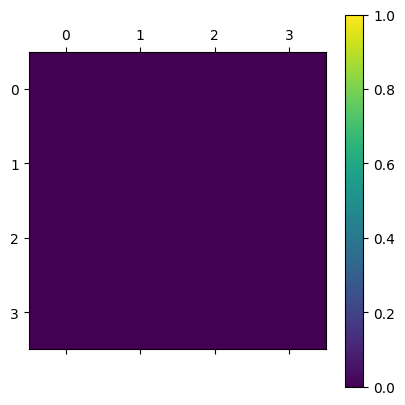

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]


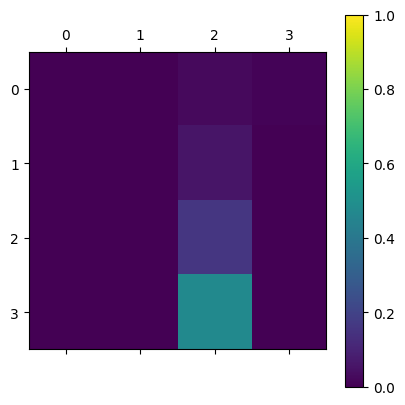

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 1. 2. 3.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 2. 0.]]


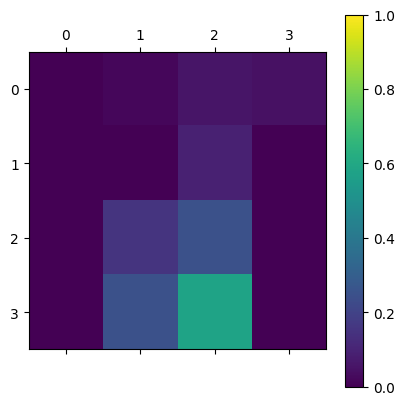

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 2. 1. 0.]]


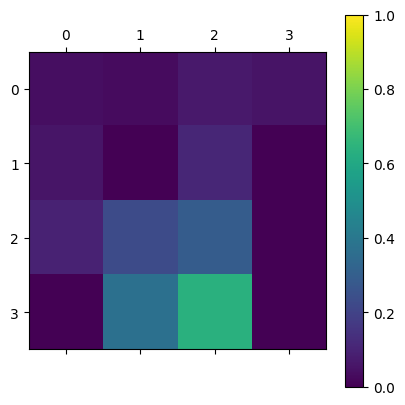

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 2. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


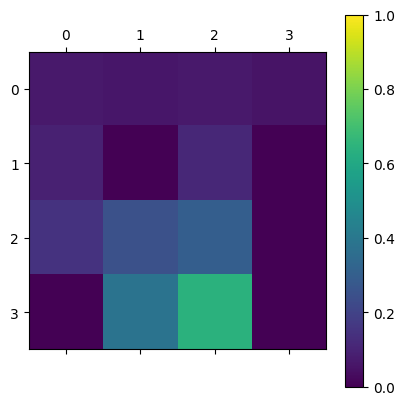

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


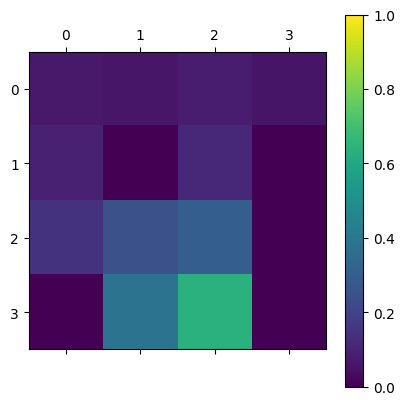

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


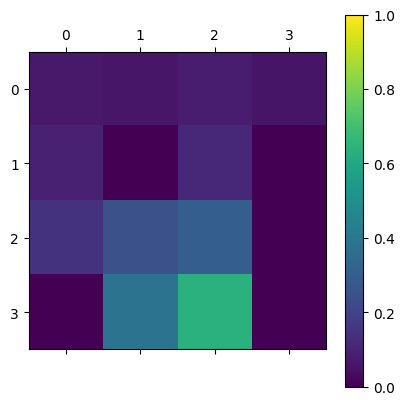

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


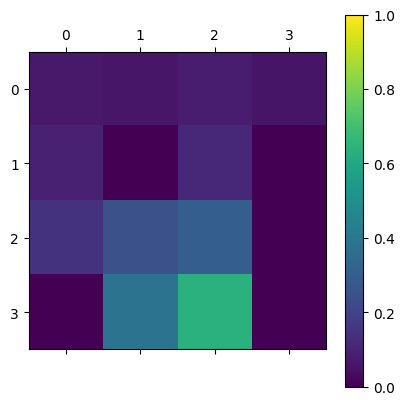

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


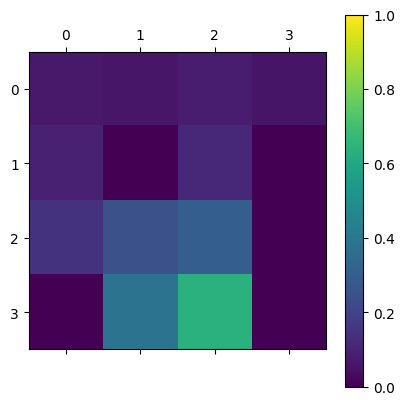

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


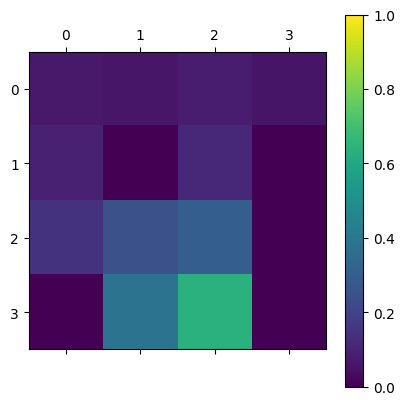

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


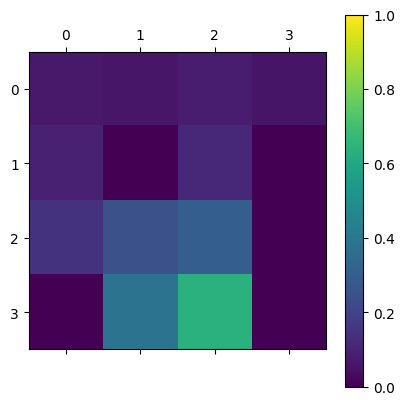

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


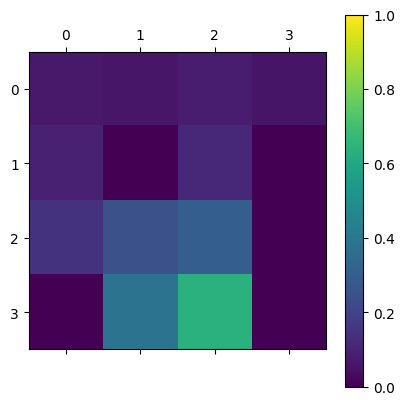

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


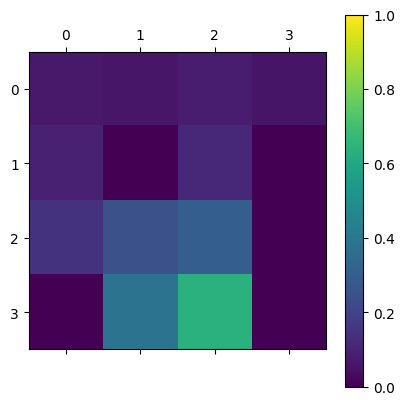

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


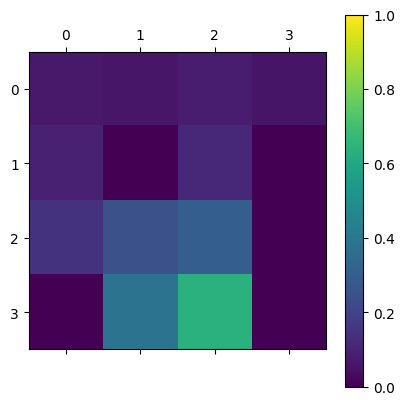

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


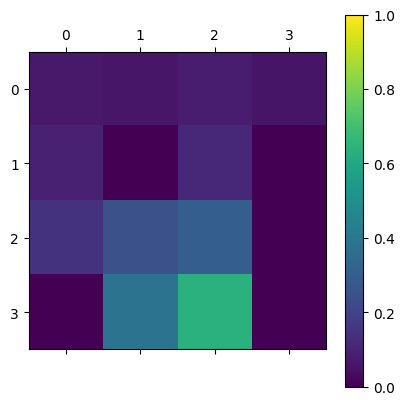

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


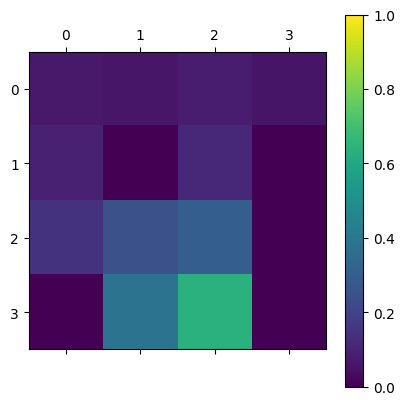

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [711]:
policy, v = policy_iteration(env, go_left_policy(env))

<mark>TODO-12</mark> Answer the following questions.

*   Explain the difference between optimal policy in `slippery FrozenLake` and `FrozenLake`.

<mark>Answer for TODO-12</mark>
*  If the environment is FrozenLake which without slippery, then we should do and consider only the action toward the state which have maximum return. Because when we do action the next state is fixed.

*  However, if the environment is slippery FrozenLake, if we do action, next state can be state which we do not expected. So in this case we should consider the action that can avoid the hole first. And then consider the return.

*  Therefore, with slippery FrozenLake, the optimal policy considers not to reach hole and maximize the return, Therefore the policy is not just same as action toward maximum reward. However, FrozenLake have optimal policy which only consider the reward.